In [2]:
import numpy as np


class MDP:
    '''A simple MDP class.  It includes the following members'''

    def __init__(self, T, R, discount):
        '''Constructor for the MDP class

        Inputs:
        T -- Transition function: |A| x |S| x |S'| array
        R -- Reward function: |A| x |S| array
        discount -- discount factor: scalar in [0,1)

        The constructor verifies that the inputs are valid and sets
        corresponding variables in a MDP object'''

        assert T.ndim == 3, "Invalid transition function: it should have 3 dimensions"
        self.nActions = T.shape[0]
        self.nStates = T.shape[1]
        assert T.shape == (
        self.nActions, self.nStates, self.nStates), "Invalid transition function: it has dimensionality " + repr(
            T.shape) + ", but it should be (nActions,nStates,nStates)"
        assert (
        abs(T.sum(2) - 1) < 1e-5).all(), "Invalid transition function: some transition probability does not equal 1"
        self.T = T
        assert R.ndim == 2, "Invalid reward function: it should have 2 dimensions"
        assert R.shape == (self.nActions, self.nStates), "Invalid reward function: it has dimensionality " + repr(
            R.shape) + ", but it should be (nActions,nStates)"
        self.R = R
        assert 0 <= discount < 1, "Invalid discount factor: it should be in [0,1)"
        self.discount = discount

    def valueIteration(self, initialV, nIterations=np.inf, tolerance=0.01):
        '''Value iteration procedure
        V <-- max_a R^a + gamma T^a V

        Inputs:
        initialV -- Initial value function: array of |S| entries
        nIterations -- limit on the # of iterations: scalar (default: infinity)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs:
        V -- Value function: array of |S| entries
        iterId -- # of iterations performed: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        V = np.copy(initialV)
        iterId = 0
        epsilon = 0

        # V.shape = (nStates, 1)
        V = np.reshape(V, (self.nStates, 1))
        #V = V.T
        V = V.astype(float)

        while iterId < nIterations:
            V_old = np.copy(V)

            iterId = iterId + 1
            for s in range(self.nStates):
                V[s] = np.amax(np.reshape(self.R[:, s], (self.nActions, 1)) + self.discount * np.matmul(self.T[:, s, :], V_old), axis=0, keepdims=False)
            epsilon = np.max(np.abs(V - V_old))

            if epsilon < tolerance :
                break
        policy = self.extractPolicy(V)

        return [policy , V, iterId, epsilon]

    def extractPolicy(self, V):
        '''Procedure to extract a policy from a value function
        pi <-- argmax_a R^a + gamma T^a V

        Inputs:
        V -- Value function: array of |S| entries

        Output:
        policy -- Policy: array of |S| entries'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        policy = np.zeros(self.nStates, dtype=int)
        #print('hi')

        V = np.reshape(V, (self.nStates, 1))


        for s in range(self.nStates):
            #print(np.argmax(np.reshape(self.R[:, s], (self.nActions,1)) + self.discount * np.matmul(self.T[:, s, :], V), axis=0))
            policy[s] = np.argmax(np.reshape(self.R[:, s], (self.nActions,1)) + self.discount * np.matmul(self.T[:, s, :], V), axis=0)
            #print(np.argmax(self.R[:, s] + self.discount * np.matmul(self.T[:, s, :], V), axis=0))
        #print(policy)
        return policy

    def evaluatePolicy(self, policy):
        '''Evaluate a policy by solving a system of linear equations
        V^pi = R^pi + gamma T^pi V^pi

        Input:
        policy -- Policy: array of |S| entries

        Ouput:
        V -- Value function: array of |S| entries'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        V = np.zeros(self.nStates)
        R = np.zeros(self.nStates)
        T = np.zeros((self.nStates, self.nStates))

        #print(R.shape)
        #print(policy)

        for s in range(self.nStates):
            a = policy[s]
            #print(a)
            #print(s)
            R[s] = self.R[a, s]
            T[s, :] = self.T[a, s, :]

        V = np.linalg.solve(np.identity(self.nStates)-self.discount*T, R)

        return V


    def policyIteration(self, initialPolicy, nIterations=np.inf):
        '''Policy iteration procedure: alternate between policy
        evaluation (solve V^pi = R^pi + gamma T^pi V^pi) and policy
        improvement (pi <-- argmax_a R^a + gamma T^a V^pi).

        Inputs:
        initialPolicy -- Initial policy: array of |S| entries
        nIterations -- limit on # of iterations: scalar (default: inf)

        Outputs:
        policy -- Policy: array of |S| entries
        V -- Value function: array of |S| entries
        iterId -- # of iterations peformed by modified policy iteration: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        policy = initialPolicy
        V = np.zeros(self.nStates)
        iterId = 0

        while iterId < nIterations:
            iterId = iterId + 1
            old_policy = np.copy(policy)
            V = self.evaluatePolicy(policy)
            #print(policy)
            policy = self.extractPolicy(V)
            if np.array_equal(policy, old_policy):
                break

        return [policy, V, iterId]

    def evaluatePolicyPartially(self, policy, initialV, nIterations=np.inf, tolerance=0.01):
        '''Partial policy evaluation:
        Repeat V^pi <-- R^pi + gamma T^pi V^pi

        Inputs:
        policy -- Policy: array of |S| entries
        initialV -- Initial value function: array of |S| entries
        nIterations -- limit on the # of iterations: scalar (default: infinity)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs:
        V -- Value function: array of |S| entries
        iterId -- # of iterations performed: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        V = np.copy(initialV)
        iterId = 0
        epsilon = 0

        R = np.zeros((self.nStates, 1), dtype=float)
        T = np.zeros((self.nStates, self.nStates), dtype=float)
        V = np.reshape(V, ((self.nStates, 1)))
        V = V.astype(float)


        for s in range(self.nStates):
            R[s] = self.R[policy[s], s]
            T[s, :] = self.T[policy[s], s, :]

        while iterId < nIterations:
            iterId = iterId + 1
            V_old = V
            V = R + self.discount*np.reshape(np.matmul(T, V_old), (self.nStates, 1))
            epsilon = np.max(np.abs(V - V_old))

            if epsilon < tolerance:
                break

        return [V, iterId, epsilon]

    def modifiedPolicyIteration(self, initialPolicy, initialV, nEvalIterations=5, nIterations=np.inf, tolerance=0.01):
        '''Modified policy iteration procedure: alternate between
        partial policy evaluation (repeat a few times V^pi <-- R^pi + gamma T^pi V^pi)
        and policy improvement (pi <-- argmax_a R^a + gamma T^a V^pi)

        Inputs:
        initialPolicy -- Initial policy: array of |S| entries
        initialV -- Initial value function: array of |S| entries
        nEvalIterations -- limit on # of iterations to be performed in each partial policy evaluation: scalar (default: 5)
        nIterations -- limit on # of iterations to be performed in modified policy iteration: scalar (default: inf)
        tolerance -- threshold on ||V^n-V^n+1||_inf: scalar (default: 0.01)

        Outputs:
        policy -- Policy: array of |S| entries
        V -- Value function: array of |S| entries
        iterId -- # of iterations peformed by modified policy iteration: scalar
        epsilon -- ||V^n-V^n+1||_inf: scalar'''

        # temporary values to ensure that the code compiles until this
        # function is coded
        policy = initialPolicy
        V = initialV
        iterId = 0
        epsilon = 0

        while iterId < nIterations:
            iterId = iterId + 1

            [V,_,_] = self.evaluatePolicyPartially(policy, V, nEvalIterations, tolerance)
            policy = self.extractPolicy(V)
            V_old = np.copy(V)
            [_, V, _, _] = self.valueIteration(V, 1)

            epsilon = np.max(abs(V - V_old))

            if epsilon < tolerance:
                break


        return [policy, V, iterId, epsilon]



In [19]:
#import numpy as np
#import MDP

class RL2:
    
    def __init__(self,mdp,sampleReward):
        '''Constructor for the RL class

        Inputs:
        mdp -- Markov decision process (T, R, discount)
        sampleReward -- Function to sample rewards (e.g., bernoulli, Gaussian).
        This function takes one argument: the mean of the distributon and 
        returns a sample from the distribution.
        '''

        self.mdp = mdp
        self.sampleReward = sampleReward

    def sampleRewardAndNextState(self,state,action):
        '''Procedure to sample a reward and the next state
        reward ~ Pr(r)
        nextState ~ Pr(s'|s,a)

        Inputs:
        state -- current state
        action -- action to be executed

        Outputs: 
        reward -- sampled reward
        nextState -- sampled next state
        '''

        reward = self.sampleReward(self.mdp.R[action,state])
        cumProb = np.cumsum(self.mdp.T[action,state,:]) #cumulative at each point
        nextState = np.where(cumProb >= np.random.rand(1))[0][0]
        return [reward,nextState]

    def sampleSoftmaxPolicy(self,policyParams,state):
        '''Procedure to sample an action from stochastic policy
        pi(a|s) = exp(policyParams(a,s))/[sum_a' exp(policyParams(a',s))])
        This function should be called by reinforce() to selection actions

        Inputs:
        policyParams -- parameters of a softmax policy (|A|x|S| array)
        state -- current state

        Outputs: 
        action -- sampled action
        '''

        # temporary value to ensure that the code compiles until this
        # function is coded
        action = 0
        
        policy = policyParams[:, state]
        policy = np.exp(policy)
        policy = policy/np.sum(policy)
        cumProb = np.cumsum(policy)
        action = np.where(cumProb >= np.random.rand(1))[0][0]
        
        return action

    def modelBasedRL(self,s0,defaultT,initialR,nEpisodes,nSteps,epsilon=0):
        '''Model-based Reinforcement Learning with epsilon greedy 
        exploration.  This function should use value iteration,
        policy iteration or modified policy iteration to update the policy at each step

        Inputs:
        s0 -- initial state
        defaultT -- default transition function when a state-action pair has not been vsited
        initialR -- initial estimate of the reward function
        nEpisodes -- # of episodes (one episode consists of a trajectory of nSteps that starts in s0
        nSteps -- # of steps per episode
        epsilon -- probability with which an action is chosen at random

        Outputs: 
        V -- final value function
        policy -- final policy
        '''

        # temporary values to ensure that the code compiles until this
        # function is coded
        episode = 0
        
        V = np.zeros(self.mdp.nStates)
        policy = np.zeros(self.mdp.nStates,int)  
        n_s_a = np.zeros((self.mdp.nActions, self.mdp.nStates))  
        n_s_a_s_next = np.zeros((self.mdp.nActions, self.mdp.nStates, self.mdp.nStates))
        
        cul_rewards = np.zeros(nEpisodes)
        
        #empirical MDP, used to record empirical transition and reward
        mdp_empirical = MDP(defaultT,initialR,self.mdp.discount) 
        
        
        while episode < nEpisodes:
            step = 0
            s = s0
            #print(transitionT)
            cul_reward = 0
            while step < nSteps:
                uni = np.random.rand(1)

                if uni < epsilon: # exploration
                    action = np.random.choice(self.mdp.nActions)
                else: #exploitation
                    trans = np.zeros((self.mdp.nActions, self.mdp.nStates))
                    for a in range(self.mdp.nActions):
                        trans[a,:] = mdp_empirical.T[a,s,:]
                
                    Qvalues = mdp_empirical.R[:,s] + self.mdp.discount*np.matmul(trans,V)
                    action = np.argmax(Qvalues, axis=0)
                    #action = Q_s.argmax()
                
                # reward and nextState from true model
                [reward, nextState] = self.sampleRewardAndNextState(s,action)
                cul_reward = cul_reward+reward*self.mdp.discount**step
                #update counts
                n_s_a[action, s] = n_s_a[action, s]+1
                n_s_a_s_next[action, s, nextState] = n_s_a_s_next[action, s, nextState]+1
                
                #update transition
                for s_prime in range(self.mdp.nStates):
                    mdp_empirical.T[action, s, s_prime] = n_s_a_s_next[action, s, s_prime]/n_s_a[action, s]
            
                #update reward
                mdp_empirical.R[action, s] = (reward + (n_s_a[action, s]-1)*mdp_empirical.R[action, s])/n_s_a[action,s]
                
                #print(mdp_empirical.T)
                #print(mdp_empirical.R)
                #solve
                [policy, V, iterId] = mdp_empirical.policyIteration(policy)               
                
                s = nextState
                step = step + 1
            cul_rewards[episode] = cul_reward
            episode = episode + 1
        #print(cul_rewards.shape)
        

        return [policy, cul_rewards]    

    def epsilonGreedyBandit(self,nIterations):
        '''Epsilon greedy algorithm for bandits (assume no discount factor)

        Inputs:
        nIterations -- # of arms that are pulled

        Outputs: 
        empiricalMeans -- empirical average of rewards for each arm (array of |A| entries)
        '''
        epsilon = 20/nIterations
        # temporary values to ensure that the code compiles until this
        # function is coded
        s = 0
        V = 0
        n = 0
        n_a = np.zeros(self.mdp.nActions)     
             
        empiricalMeans = np.zeros(self.mdp.nActions)
        
        rewards = np.zeros(nIterations)
        
        for iterID in range(nIterations):
            uni = np.random.rand(1)
            if uni < epsilon: # exploration
                action = np.random.choice(self.mdp.nActions)
            else: #exploitation
                action = np.argmax(empiricalMeans)
            #print(self.mdp.nActions)
            #print([action, epsilon, uni])
            # reward and nextState from true model
            [reward, nextState] = self.sampleRewardAndNextState(s,action)
            s = nextState
            rewards[iterID] = reward
            #print(reward)
            V = V+reward
            empiricalMeans[action] = (n_a[action]*empiricalMeans[action]+reward)/(n_a[action]+1)
            
            
            n = n+1
            n_a[action] = n_a[action]+1
            
            
        return [empiricalMeans,rewards]

    def thompsonSamplingBandit(self,prior,nIterations,k=1):
        '''Thompson sampling algorithm for Bernoulli bandits (assume no discount factor)

        Inputs:
        prior -- initial beta distribution over the average reward of each arm (|A|x2 matrix such that prior[a,0] is the alpha hyperparameter for arm a and prior[a,1] is the beta hyperparameter for arm a)  
        nIterations -- # of arms that are pulled
        k -- # of sampled average rewards

        Outputs: 
        empiricalMeans -- empirical average of rewards for each arm (array of |A| entries)
        '''

        # temporary values to ensure that the code compiles until this
        # function is coded
        s = 0
        V = 0
        
        rewards = np.zeros(nIterations)
        
        empiricalMeans = np.zeros(self.mdp.nActions)
        n_a = np.zeros(self.mdp.nActions)
        for iterID in range(nIterations):
            #sample
            Rs_sampled = np.zeros(self.mdp.nActions)
            for a in range(self.mdp.nActions):
                for i in range(k):
                    R_sampled = np.random.beta(prior[a,0],prior[a,1])
                    Rs_sampled[a] = Rs_sampled[a]+R_sampled
                Rs_sampled[a] = Rs_sampled[a]/k
            
            
            a_star = np.argmax(Rs_sampled)
            [reward, nextState] = self.sampleRewardAndNextState(s,a_star)
            rewards[iterID] = reward
            s = nextState
            V = V+reward
            #update prior (uncertainty) of theta
            if reward == 1:
                prior[a_star, 0] = prior[a_star, 0]+1
            else:
                prior[a_star, 1] = prior[a_star, 1]+1
            
            
            #update empiricalMeans
            empiricalMeans[a_star] = (n_a[a_star]*empiricalMeans[a_star]+reward)/(n_a[a_star]+1)
            n_a[a_star]=n_a[a_star]+1
        return [empiricalMeans, rewards]

    def UCBbandit(self,nIterations):
        '''Upper confidence bound algorithm for bandits (assume no discount factor)

        Inputs:
        nIterations -- # of arms that are pulled

        Outputs: 
        empiricalMeans -- empirical average of rewards for each arm (array of |A| entries)
        '''

        # temporary values to ensure that the code compiles until this
        # function is coded
        # temporary values to ensure that the code compiles until this
        # function is coded
        s = 0
        V = 0
        n = 0
        n_a = np.ones(self.mdp.nActions)
             
        empiricalMeans = np.zeros(self.mdp.nActions)
        
        rewards = np.zeros(nIterations)
        
        for iterID in range(nIterations):
            there_is_zero = False
            for a in range(self.mdp.nActions):
                if empiricalMeans[a] == 0:
                    there_is_zero = True
                    action = a
                    break
            if there_is_zero == False:
                UCB = empiricalMeans + np.sqrt(2*np.log(n)/np.log(n_a))
                action = np.argmax(UCB)
            # reward and nextState from true model
            [reward, nextState] = self.sampleRewardAndNextState(s,action)
            rewards[iterID] = reward
            s = nextState
            #print(reward)
            V = V+reward
            empiricalMeans[action] = (n_a[action]*empiricalMeans[action]+reward)/(n_a[action]+1)
            
            n = n+1
            n_a[action] = n_a[action]+1
            
        return [empiricalMeans, rewards]

    def reinforce(self,s0,initialPolicyParams,nEpisodes,nSteps):
        '''reinforce algorithm.  Learn a stochastic policy of the form
        pi(a|s) = exp(policyParams(a,s))/[sum_a' exp(policyParams(a',s))]).
        This function should call the function sampleSoftmaxPolicy(policyParams,state) to select actions

        Inputs:
        s0 -- initial state
        initialPolicyParams -- parameters of the initial policy (array of |A|x|S| entries)
        nEpisodes -- # of episodes (one episode consists of a trajectory of nSteps that starts in s0)
        nSteps -- # of steps per episode

        Outputs: 
        policyParams -- parameters of the final policy (array of |A|x|S| entries)
        '''

        # temporary values to ensure that the code compiles until this
        # function is coded
        policyParams = initialPolicyParams
        # policy is determined by pi(a|s). s determines the parameters for a.
        
        episode = 0
        
        n_s_a = np.zeros((self.mdp.nActions, self.mdp.nStates))
        
        cul_rewards = np.zeros(nEpisodes)
        
        while episode < nEpisodes:
            step = 0
            state = s0
            history = np.zeros((nSteps, 3), dtype = int)#array of (s,a,r)
            
            cul_reward = 0
            #print(transitionT)
            
            #generate episode
            while step < nSteps:
                #action
                action = self.sampleSoftmaxPolicy(policyParams,state)
                
                # reward and nextState from true model
                [reward, nextState] = self.sampleRewardAndNextState(state,action)
                cul_reward = cul_reward+reward*self.mdp.discount**step
                history[step, :] = [state, action, reward]
                n_s_a[action, state] = n_s_a[action, state]+1
                
                state = nextState
                step = step + 1
            cul_rewards[episode] = cul_reward
            
            step = 0
            #update theta
            while step < nSteps:
                future_rewards = history[step:, 2]
                discounts = np.zeros((nSteps-step,1))
                discounts = [np.power(self.mdp.discount, i-step) for i in range(step, nSteps)]
                G_n = np.dot(discount, future_rewards)
                
                #update policy
                s_n = history[step, 0]
                a_n = history[step, 1]
                #print([s_n, a_n])
                gradient = np.zeros((self.mdp.nActions, 1))

                for j in range(self.mdp.nActions):
                    p_theta = np.exp(policyParams[j,s_n])/np.sum(np.exp(policyParams[:,s_n]))
                    if j == a_n:
                        gradient[j] = 1 - p_theta
                    else:
                        gradient[j] = 0 - p_theta
                
                #print(gradient.shape)
                
                alpha = 0.1
                #print(alpha)
                #print((policyParams[:,s_n]+alpha*np.power(self.mdp.discount, step)*gradient).shape)
                #print((alpha*np.power(self.mdp.discount, step)*gradient).shape)
                policyParams[:,s_n] = policyParams[:,s_n]+np.reshape(alpha*np.power(self.mdp.discount, step)*gradient,(policyParams[:,s_n]).shape)
                
                step = step + 1
                
            episode = episode + 1 
            
        return [policyParams, cul_rewards]
    
    def qLearning(self,s0,initialQ,nEpisodes,nSteps,epsilon=0,temperature=0):
        '''qLearning algorithm.  Epsilon exploration and Boltzmann exploration
        are combined in one procedure by sampling a random action with
        probabilty epsilon and performing Boltzmann exploration otherwise.
        When epsilon and temperature are set to 0, there is no exploration.

        Inputs:
        s0 -- initial state
        initialQ -- initial Q function (|A|x|S| array)
        nEpisodes -- # of episodes (one episode consists of a trajectory of nSteps that starts in s0
        nSteps -- # of steps per episode
        epsilon -- probability with which an action is chosen at random
        temperature -- parameter that regulates Boltzmann exploration

        Outputs:
        Q -- final Q function (|A|x|S| array)
        policy -- final policy
        '''

        # temporary values to ensure that the code compiles until this
        # function is coded

        episode = 0
        Q = initialQ
        n = np.zeros((self.mdp.nActions, self.mdp.nStates))

        cul_rewards = np.zeros(nEpisodes)
        while episode < nEpisodes:
            #Q_old = np.copy(Q)
            cul_reward = 0

            step = 0
            s = s0
            while step < nSteps:
                Q_s = Q[:,s]
                uni = np.random.rand(1)

                if uni < epsilon: # exploration
                    action = np.random.choice(self.mdp.nActions)
                else: #Boltzmann
                    if temperature != 0:
                        Q_s = np.reshape(Q_s, (self.mdp.nActions, 1))
                        p_s = np.exp(Q_s/temperature)
                        p_s = p_s/np.sum(p_s)
                        action = np.random.choice(self.mdp.nActions, size = 1, p = p_s.flatten())
                    else:
                        Q_s = np.reshape(Q_s, (self.mdp.nActions, 1))
                        action = np.argmax(Q_s, axis=0)
                        #action = Q_s.argmax()


                [reward, nextState] = self.sampleRewardAndNextState(s,action)
                cul_reward = cul_reward+reward*self.mdp.discount**step

                n[action, s] = n[action, s]+1
                alpha = 1/n[action, s]
                Q_s_a_next = Q[:, nextState]
                Q_s_a_next = np.reshape(Q_s_a_next, (self.mdp.nActions, 1))

                Q[action, s] = Q[action, s] + alpha * (reward + self.mdp.discount * (np.amax(Q_s_a_next, axis=0)) - Q[action,s])
                s = nextState
                step = step + 1
            #if max(abs(Q-Q_old)) <
            V = np.amax(Q, axis=0)
            policy = self.mdp.extractPolicy(V)
            cul_rewards[episode] = cul_reward
            episode = episode + 1

        return [Q,policy, cul_rewards]

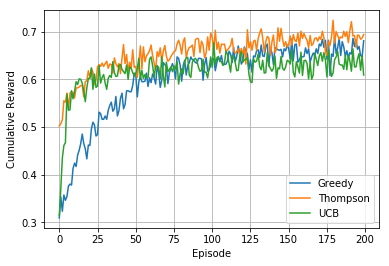

In [20]:
import matplotlib.pyplot as plt
def sampleBernoulli(mean):
    ''' function to obtain a sample from a Bernoulli distribution

    Input:
    mean -- mean of the Bernoulli
    
    Output:
    sample -- sample (0 or 1)
    '''

    if np.random.rand(1) < mean: return 1
    else: return 0


# Multi-arm bandit problems (3 arms with probabilities 0.3, 0.5 and 0.7)
T = np.array([[[1]],[[1]],[[1]]])
R = np.array([[0.3],[0.5],[0.7]])
discount = 0.999
mdp = MDP(T,R,discount)
banditProblem = RL2(mdp,sampleBernoulli)

# Test epsilon greedy strategy
Rewards=[]
for i in range(1000):
    [_, rewards] = banditProblem.epsilonGreedyBandit(nIterations=200)
    Rewards.append(rewards)
plt.plot(range(200),np.mean(Rewards, axis=0), label='Greedy')

#empiricalMeans = banditProblem.epsilonGreedyBandit(nIterations=200)
#print("\nepsilonGreedyBandit results")
#print(empiricalMeans)

# Test Thompson sampling strategy
Rewards=[]
for i in range(1000):
    [_, rewards] = banditProblem.thompsonSamplingBandit(prior=np.ones([mdp.nActions,2]),nIterations=200)
    Rewards.append(rewards)
plt.plot(range(200),np.mean(Rewards, axis=0), label='Thompson')

#print("\nthompsonSamplingBandit results")
#print(empiricalMeans)

# Test UCB strategy
Rewards=[]
for i in range(1000):
    [_, rewards] = banditProblem.UCBbandit(nIterations=200)
    Rewards.append(rewards)
plt.plot(range(200),np.mean(Rewards, axis=0), label='UCB')

#print("\nUCBbandit results")
#print(empiricalMeans)

plt.grid()
plt.legend()
plt.title("")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.show()

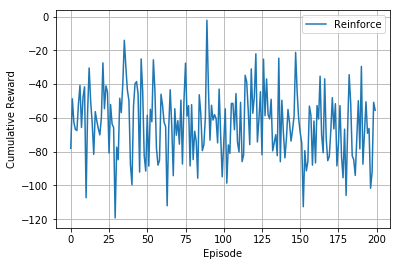


Q-learning results
[[ 0.68423989  1.03438497 -0.04708783  0.99535838  1.87839495  0.82837896
   0.26568072  0.14548461  0.63567226 -0.25111839  0.24463346 -0.08067299
   0.29237789  0.26196349  0.63701472  0.57401024 -0.70918641]
 [ 0.63759779 -0.01044344  0.58367406  0.20498444 -0.29745002  0.28240681
   1.19914952  0.03664036  0.67178319  0.6329534   0.58690368  0.16441182
   1.12111172  1.14211414  1.12164275  0.50040943  0.01006622]
 [ 0.31472881 -0.13798781  1.59011308  0.4036164   0.01083046  0.16407713
   0.23958299  1.15057823  0.36654033  0.74307281  0.67992803  0.31763878
   0.62452147  0.68931523 -0.26937848  0.35453083  1.27467191]
 [ 0.46763862  0.27079825  0.6025712  -0.14981581 -0.06957329  1.39147892
   0.72686534 -0.0342327   0.79660999  0.81705307  0.65106377  1.0762867
   0.03172314  0.12839002  0.56772325  0.20974194  0.87961954]]


In [105]:
import numpy as np
import matplotlib.pyplot as plt

#import MDP
#import RL2


''' Construct a simple maze MDP

  Grid world layout:

  ---------------------
  |  0 |  1 |  2 |  3 |
  ---------------------
  |  4 |  5 |  6 |  7 |
  ---------------------
  |  8 |  9 | 10 | 11 |
  ---------------------
  | 12 | 13 | 14 | 15 |
  ---------------------

  Goal state: 15 
  Bad state: 9
  End state: 16

  The end state is an absorbing state that the agent transitions 
  to after visiting the goal state.

  There are 17 states in total (including the end state) 
  and 4 actions (up, down, left, right).'''

# Transition function: |A| x |S| x |S'| array
T = np.zeros([4,17,17])
a = 0.8;  # intended move
b = 0.1;  # lateral move

# up (a = 0)

T[0,0,0] = a+b;
T[0,0,1] = b;

T[0,1,0] = b;
T[0,1,1] = a;
T[0,1,2] = b;

T[0,2,1] = b;
T[0,2,2] = a;
T[0,2,3] = b;

T[0,3,2] = b;
T[0,3,3] = a+b;

T[0,4,4] = b;
T[0,4,0] = a;
T[0,4,5] = b;

T[0,5,4] = b;
T[0,5,1] = a;
T[0,5,6] = b;

T[0,6,5] = b;
T[0,6,2] = a;
T[0,6,7] = b;

T[0,7,6] = b;
T[0,7,3] = a;
T[0,7,7] = b;

T[0,8,8] = b;
T[0,8,4] = a;
T[0,8,9] = b;

T[0,9,8] = b;
T[0,9,5] = a;
T[0,9,10] = b;

T[0,10,9] = b;
T[0,10,6] = a;
T[0,10,11] = b;

T[0,11,10] = b;
T[0,11,7] = a;
T[0,11,11] = b;

T[0,12,12] = b;
T[0,12,8] = a;
T[0,12,13] = b;

T[0,13,12] = b;
T[0,13,9] = a;
T[0,13,14] = b;

T[0,14,13] = b;
T[0,14,10] = a;
T[0,14,15] = b;

T[0,15,16] = 1;
T[0,16,16] = 1;

# down (a = 1)

T[1,0,0] = b;
T[1,0,4] = a;
T[1,0,1] = b;

T[1,1,0] = b;
T[1,1,5] = a;
T[1,1,2] = b;

T[1,2,1] = b;
T[1,2,6] = a;
T[1,2,3] = b;

T[1,3,2] = b;
T[1,3,7] = a;
T[1,3,3] = b;

T[1,4,4] = b;
T[1,4,8] = a;
T[1,4,5] = b;

T[1,5,4] = b;
T[1,5,9] = a;
T[1,5,6] = b;

T[1,6,5] = b;
T[1,6,10] = a;
T[1,6,7] = b;

T[1,7,6] = b;
T[1,7,11] = a;
T[1,7,7] = b;

T[1,8,8] = b;
T[1,8,12] = a;
T[1,8,9] = b;

T[1,9,8] = b;
T[1,9,13] = a;
T[1,9,10] = b;

T[1,10,9] = b;
T[1,10,14] = a;
T[1,10,11] = b;

T[1,11,10] = b;
T[1,11,15] = a;
T[1,11,11] = b;

T[1,12,12] = a+b;
T[1,12,13] = b;

T[1,13,12] = b;
T[1,13,13] = a;
T[1,13,14] = b;

T[1,14,13] = b;
T[1,14,14] = a;
T[1,14,15] = b;

T[1,15,16] = 1;
T[1,16,16] = 1;

# left (a = 2)

T[2,0,0] = a+b;
T[2,0,4] = b;

T[2,1,1] = b;
T[2,1,0] = a;
T[2,1,5] = b;

T[2,2,2] = b;
T[2,2,1] = a;
T[2,2,6] = b;

T[2,3,3] = b;
T[2,3,2] = a;
T[2,3,7] = b;

T[2,4,0] = b;
T[2,4,4] = a;
T[2,4,8] = b;

T[2,5,1] = b;
T[2,5,4] = a;
T[2,5,9] = b;

T[2,6,2] = b;
T[2,6,5] = a;
T[2,6,10] = b;

T[2,7,3] = b;
T[2,7,6] = a;
T[2,7,11] = b;

T[2,8,4] = b;
T[2,8,8] = a;
T[2,8,12] = b;

T[2,9,5] = b;
T[2,9,8] = a;
T[2,9,13] = b;

T[2,10,6] = b;
T[2,10,9] = a;
T[2,10,14] = b;

T[2,11,7] = b;
T[2,11,10] = a;
T[2,11,15] = b;

T[2,12,8] = b;
T[2,12,12] = a+b;

T[2,13,9] = b;
T[2,13,12] = a;
T[2,13,13] = b;

T[2,14,10] = b;
T[2,14,13] = a;
T[2,14,14] = b;

T[2,15,16] = 1;
T[2,16,16] = 1;

# right (a = 3)

T[3,0,0] = b;
T[3,0,1] = a;
T[3,0,4] = b;

T[3,1,1] = b;
T[3,1,2] = a;
T[3,1,5] = b;

T[3,2,2] = b;
T[3,2,3] = a;
T[3,2,6] = b;

T[3,3,3] = a+b;
T[3,3,7] = b;

T[3,4,0] = b;
T[3,4,5] = a;
T[3,4,8] = b;

T[3,5,1] = b;
T[3,5,6] = a;
T[3,5,9] = b;

T[3,6,2] = b;
T[3,6,7] = a;
T[3,6,10] = b;

T[3,7,3] = b;
T[3,7,7] = a;
T[3,7,11] = b;

T[3,8,4] = b;
T[3,8,9] = a;
T[3,8,12] = b;

T[3,9,5] = b;
T[3,9,10] = a;
T[3,9,13] = b;

T[3,10,6] = b;
T[3,10,11] = a;
T[3,10,14] = b;

T[3,11,7] = b;
T[3,11,11] = a;
T[3,11,15] = b;

T[3,12,8] = b;
T[3,12,13] = a;
T[3,12,12] = b;

T[3,13,9] = b;
T[3,13,14] = a;
T[3,13,13] = b;

T[3,14,10] = b;
T[3,14,15] = a;
T[3,14,14] = b;

T[3,15,16] = 1;
T[3,16,16] = 1;

# Reward function: |A| x |S| array
R = -1 * np.ones([4,17]);

# set rewards
R[:,15] = 100;  # goal state
R[:,9] = -70;   # bad state
R[:,16] = 0;    # end state

# Discount factor: scalar in [0,1)
discount = 0.95
        
# MDP object
#mdp = MDP.MDP(T,R,discount)
mdp = MDP(T,R,discount)
# RL problem
#rlProblem = RL2.RL2(mdp,np.random.normal)
rlProblem = RL2(mdp,np.random.normal)

# Test REINFORCE 
cul_rewards=[]
for i in range(10):
    [policy, cul_reward] = rlProblem.reinforce(s0=0,initialPolicyParams=np.random.rand(mdp.nActions,mdp.nStates),nEpisodes=200,nSteps=100)
    cul_rewards.append(cul_reward)
plt.plot(range(200),np.mean(cul_rewards, axis=0), label='Reinforce')

#print("\nREINFORCE results")
#print(policy)
'''
# Test model-based RL
cul_rewards=[]
for i in range(10):
    [policy, cul_reward] = rlProblem.modelBasedRL(s0=0,defaultT=np.ones([mdp.nActions,mdp.nStates,mdp.nStates])/mdp.nStates,initialR=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0.3)  
    cul_rewards.append(cul_reward)
plt.plot(range(200),np.mean(cul_rewards, axis=0), label='Model-Based')


#print("\nmodel-based RL results")
#print(policy)

# Test Q-learning
cul_rewards=[]
for i in range(10):
    [_,_,cul_reward] = rlProblem.qLearning(s0=0,initialQ=np.zeros([mdp.nActions,mdp.nStates]),nEpisodes=200,nSteps=100,epsilon=0.05)  
    cul_rewards.append(cul_reward)
plt.plot(range(200),np.mean(cul_rewards, axis=0), label='Q-learning')
'''

plt.grid()
plt.legend()
plt.title("")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.show()

print("\nQ-learning results")
print(policy)

ModuleNotFoundError: No module named 'mpi4py'